Build the hash generation program, prove that it works:

In [1]:
!go build ./hash.go
!./hash -h

Usage of ./hash:
  -hash string
    	hash function (default "xshrr")
  -n uint
    	mod-N (default 4096)


Build a test corpus by joining random ordering of `/usr/share/dict/words` with itself 10 times:

In [2]:
!shuf /usr/share/dict/words >corpus
for i in range(10):
    !shuf /usr/share/dict/words >corpus.moar
    !paste -d ' ' corpus corpus.moar > corpus.next
    !mv corpus.next corpus
!head corpus

intermammary amphivasal preaccord inkstandish bewrayingly scarf topiarian benzidino rotorcraft emotionless infectiveness
comism mesoarial repour syphilization pompiloid signally engram grouser hydnoraceous oliviform tamboura
pyrosphere pollarchy friedelite chesser Akim aegyptilla semiclause primitive pocket centauress bestamp
wheyfaced pollinar tripotassium spiralization splenonephric nationalness exiler flectionless Dipsacaceae tombic trisection
distortive septennium bullous longways nonabridgment benzamino unshrouded physicoastronomical belyingly preoperatively unicum
immunological telakucha testamentarily prelatry dissipative resuscitator assuage unboundedness gleamingly colophony murrina
daven ethics teevee washbasket Elaphrium glossography Cluniac spermation carousingly Origenism syllable
sternofacialis ownself thuggee protectant unpleasantness inquisitive philosophocracy clefted larcenously tule curvilinearity
surrenderor auriferous vulvovaginal gymnosperm foamer pahlavi impassib

Now run all the hashes, plot their data, and describe the counts:

,count,mean,std,min,25%,50%,75%,90%,99%,max
fnv32,4096.0,57.589355,7.555368,35.0,52.0,57.0,62.0,67.0,77.00,86.0
fnv32a,4096.0,57.589355,7.523140,33.0,52.0,57.0,63.0,67.0,75.05,84.0
xshrr,4096.0,57.589355,7.706701,32.0,52.0,57.0,63.0,68.0,76.00,87.0


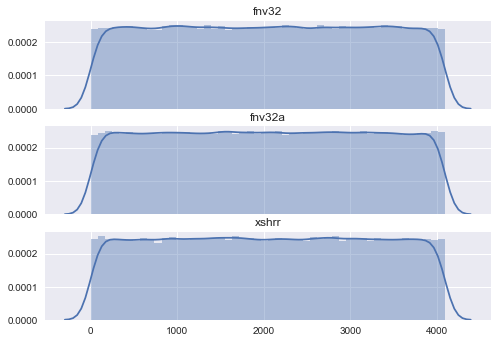

In [3]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

import pandas as pd

n = 4096
data = []

for h in ['fnv32', 'fnv32a', 'xshrr']:
    lines =!./hash -n $n -hash $h <corpus
    S = pd.Series(lines).astype('int')
    data.append((h, S))

fig, axs = plt.subplots(len(data), 1, sharex=True)
for (n, d), ax in zip(data, axs):
    ax.set_title(n)
    sns.distplot(d, ax=ax)

display(pd.DataFrame({
    n: d.value_counts().describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])
    for n, d in data
}).T)

Run benchmarks, load data, show it:

In [4]:
test_lines = !go test . -bench . -benchmem

test_data = pd.DataFrame(test_lines.fields()).iloc[1:-2]

test_data = test_data[0].str.extract(r'''
    (?x)     # now we can use comments and whitespace!
    ^
    BenchmarkHashes
    /
    (?P<hash>\w+)
    /
    (?P<corpus>.+)
    $
''', expand=True).join(test_data.drop(0, axis=1))

test_data['hash'] = test_data['hash'].astype('category')
test_data['corpus'] = test_data['corpus'].astype('category')

test_data['N'] = test_data.pop(1).astype('int')

assert (test_data.pop(3) == 'ns/op').all()
test_data['ns/op'] = test_data.pop(2).astype('float')

assert (test_data.pop(5) == 'B/op').all()
test_data['B/op'] = test_data.pop(4).astype('int')

assert (test_data.pop(7) == 'allocs/op').all()
test_data['B/op'] = test_data.pop(6).astype('int')

test_data

,hash,corpus,N,ns/op,B/op
1,XSHRR,some_stuff_I_made_up-8,200000000,7.87,0
2,XSHRR,shuf_-n50_/usr/share/dict/words-8,100000000,12.80,0
3,XSHRR,shuf_-n100_/usr/share/dict/words-8,100000000,12.60,0
4,XSHRR,(shuf_-n100_/usr/share/dict/words)^2-8,50000000,24.90,0
5,XSHRR,(shuf_-n100_/usr/share/dict/words)^3-8,50000000,40.00,0
6,XSHRR,(shuf_-n100_/usr/share/dict/words)^4-8,20000000,90.70,0
7,FNV32a,some_stuff_I_made_up-8,300000000,5.48,0
8,FNV32a,shuf_-n50_/usr/share/dict/words-8,200000000,9.13,0
9,FNV32a,shuf_-n100_/usr/share/dict/words-8,200000000,9.17,0
10,FNV32a,(shuf_-n100_/usr/share/dict/words)^2-8,100000000,20.50,0


Simple plot of ns/op (vs increasing token complexity):

,count,mean,std,min,25%,50%,75%,max
hash,,,,,,,,
CoreFNV32a,6.0,93.683333,59.182985,43.80,57.625,70.400,109.200,202.0
FNV32a,6.0,27.313333,30.112181,5.48,9.140,14.835,31.300,84.7
XSHRR,6.0,31.478333,31.259316,7.87,12.650,18.850,36.225,90.7


hash
CoreFNV32a    Axes(0.125,0.125;0.775x0.755)
FNV32a        Axes(0.125,0.125;0.775x0.755)
XSHRR         Axes(0.125,0.125;0.775x0.755)
Name: ns/op, dtype: object

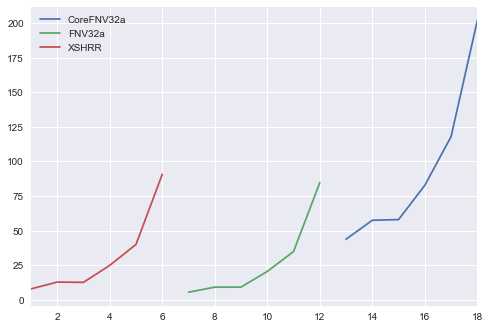

In [5]:
display(test_data.groupby('hash')['ns/op'].describe().unstack())

test_data.groupby('hash')['ns/op'].plot(legend=True)